# Import

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
import torch.optim as optim
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

 ## A–Z Handwritten Alphabets Dataset Overview

The dataset contains grayscale images of handwritten English alphabet letters collected from thousands of individuals, resulting in approximately **372,450 labeled samples**.

Each record represents one handwritten character and is stored as a **flattened 28×28 image (784 pixels)** along with its corresponding label.


### Dataset Format

The dataset is provided in **CSV format**, with the following structure:

* **Label**: An integer value from `0` to `25`, representing letters **A (0) to Z (25)**.
* **Pixel1 … Pixel784**: Flattened pixel values from a 28×28 grayscale image (each value from `0` to `255`).


## Loading the dataset

In [ ]:
data = pd.read_csv("data/a_z_handwritten_data.csv").astype(np.float32)

In [18]:
data.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
len(data)

372450

### Checking Min, Max Pixel Value

In [ ]:
print("Max value in dataset:", data.values.max())
print("Min value in dataset:", data.values.min())

Max value in dataset: 255.0
Min value in dataset: 0.0


#### Checking Image Dimensions

In [28]:
data.iloc[1].values.shape

(785,)

### Reshapes and normalizes the images

In [ ]:
labels = data.iloc[:,0].values  # 0–25
pixels = data.iloc[:,1:].values.reshape(-1, 1, 28, 28) / 255.0

### Convert to tensors

In [ ]:
X = torch.tensor(pixels)
y = torch.tensor(labels, dtype=torch.long)

### Splitting the Dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=64, num_workers=2)

### CNN Model Definition for A–Z Handwritten Alphabet Classification

- **Input shape**: Grayscale images of size 28×28 with 1 channel.
- **Architecture**:
  - 3 convolutional layers with ReLU activation and max pooling:
    - Conv1: 32 filters → 28×28 → 14×14
    - Conv2: 64 filters → 14×14 → 7×7
    - Conv3: 128 filters → 7×7 → 3×3
  - Flattened feature maps (128 × 3 × 3 = 1152 features)
  - Fully connected dense layer with 128 neurons and ReLU activation
  - Dropout layer to prevent overfitting
  - Output layer with 26 units (for 26 letter classes) and no activation (logits)
- **Device selection**: Automatically uses GPU if available, otherwise CPU.

In [ ]:
import torch.nn as nn

class AZ_CNN(nn.Module):
    def __init__(self, num_classes=26):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),   
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Checking for CUDA Availability

In [30]:
torch.cuda.is_available()

True

### Training and Evaluation Loop for A–Z CNN Model

In [ ]:
model = AZ_CNN(num_classes=26).to(device)

criterion = nn.CrossEntropyLoss() # Loss function  
optimizer = optim.Adam(model.parameters(), lr=1e-3) # Adam optimizer with a learning rate of 0.001.
epochs = 10

# Trains the model for one full pass over the training data, updating weights using backpropagation and tracking average loss and accuracy.
def train_epoch(loader):
    model.train()
    total_loss, correct = 0, 0
    for Xb, yb in tqdm(loader, desc="Train"):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item() * Xb.size(0)
        correct += (preds.argmax(1) == yb).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# Evaluates the model on the validation or test set without gradient updates, computing the average loss and classification accuracy.
def eval_epoch(loader):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            total_loss += criterion(preds, yb).item() * Xb.size(0)
            correct += (preds.argmax(1) == yb).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# Tracking
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training Loop
for epoch in range(1, epochs+1):
    train_loss, train_acc = train_epoch(train_loader)
    test_loss, test_acc = eval_epoch(test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    print(f"Epoch {epoch:2d}: Train {train_loss:.4f}, {100*train_acc:.2f}%, Test {test_loss:.4f}, {100*test_acc:.2f}%")


Train: 100%|██████████| 4074/4074 [02:03<00:00, 32.95it/s]


Epoch  1: Train 0.2946, 91.50%, Test 0.0680, 98.18%


Train: 100%|██████████| 4074/4074 [03:08<00:00, 21.65it/s]


Epoch  2: Train 0.1092, 97.07%, Test 0.0576, 98.41%


Train: 100%|██████████| 4074/4074 [03:21<00:00, 20.18it/s]


Epoch  3: Train 0.0822, 97.78%, Test 0.0416, 98.88%


Train: 100%|██████████| 4074/4074 [02:37<00:00, 25.95it/s]


Epoch  4: Train 0.0649, 98.25%, Test 0.0440, 98.86%


Train: 100%|██████████| 4074/4074 [03:00<00:00, 22.51it/s]


Epoch  5: Train 0.0544, 98.51%, Test 0.0386, 99.08%


Train: 100%|██████████| 4074/4074 [01:55<00:00, 35.32it/s]


Epoch  6: Train 0.0471, 98.68%, Test 0.0374, 99.01%


Train: 100%|██████████| 4074/4074 [02:13<00:00, 30.53it/s]


Epoch  7: Train 0.0423, 98.81%, Test 0.0339, 99.16%


Train: 100%|██████████| 4074/4074 [03:29<00:00, 19.49it/s]


Epoch  8: Train 0.0370, 98.94%, Test 0.0379, 99.12%


Train: 100%|██████████| 4074/4074 [04:29<00:00, 15.14it/s]


Epoch  9: Train 0.0339, 99.01%, Test 0.0332, 99.20%


Train: 100%|██████████| 4074/4074 [04:50<00:00, 14.04it/s]


Epoch 10: Train 0.0312, 99.09%, Test 0.0351, 99.20%


### Training Progress Visualization

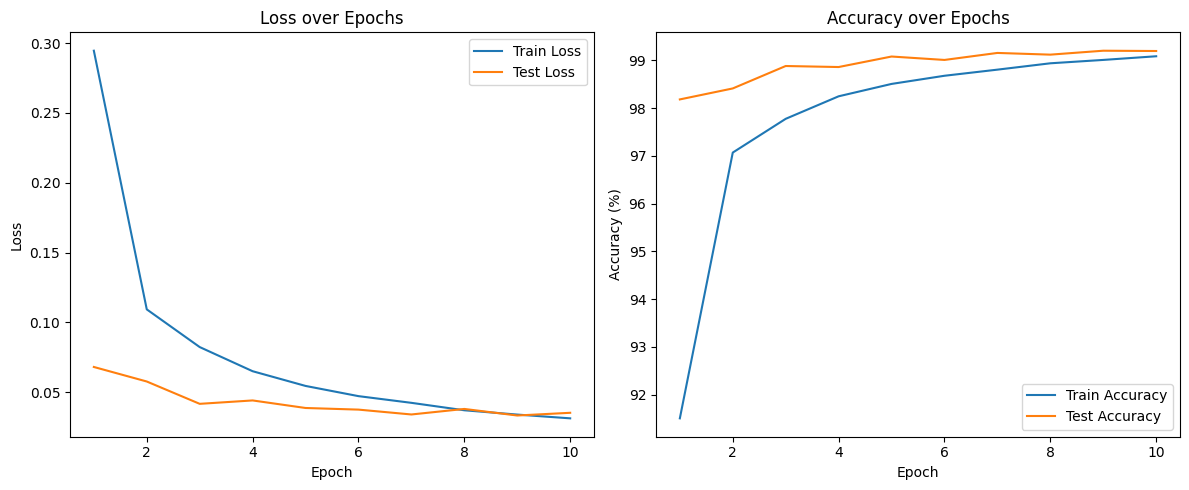

In [ ]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, [acc * 100 for acc in train_accuracies], label='Train Accuracy')
plt.plot(epochs_range, [acc * 100 for acc in test_accuracies], label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


### Visualize 10 random elements from test set and model results for those elements

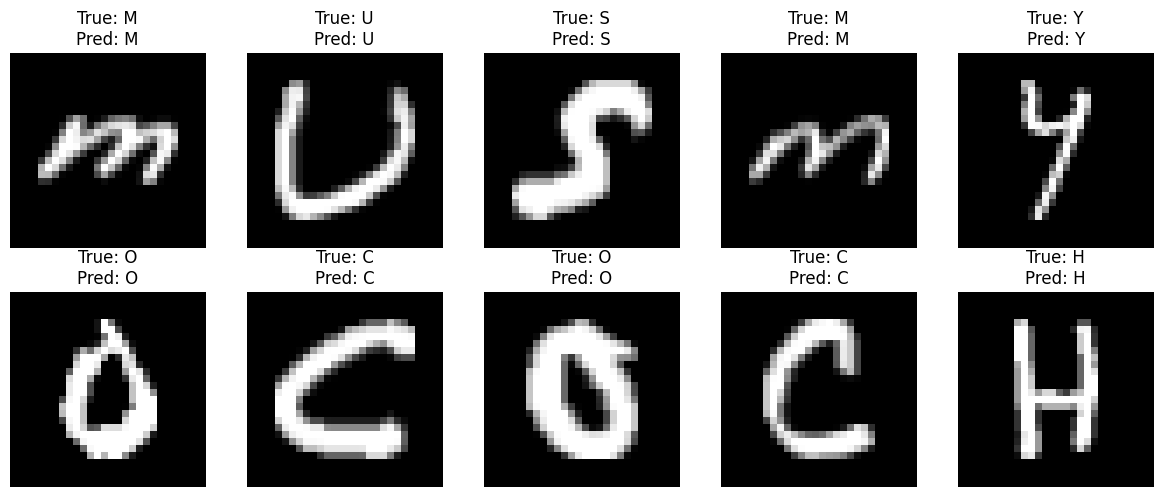

In [ ]:
model.eval()
fig, axs = plt.subplots(2,5, figsize=(12,5))
indices = random.sample(range(len(X_test)), 10)
for i, idx in enumerate(indices):
    img, lbl = X_test[idx], y_test[idx]
    pred = model(img.unsqueeze(0).to(device)).argmax(dim=1).item()
    ax = axs[i//5, i%5]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"True: {chr(lbl+65)}\nPred: {chr(pred+65)}")
    ax.axis('off')
plt.tight_layout(); 
plt.show()
